In [ ]:
# 1. Import pandas
import pandas as pd
import numpy as np
from sklearn import linear_model
from sklearn.metrics import precision_recall_fscore_support, accuracy_score
from sklearn.decomposition import PCA
from sklearn.preprocessing import PolynomialFeatures
from sklearn.linear_model import LogisticRegression
import matplotlib.pyplot as plt
import seaborn as sns

 
from sklearn.metrics.pairwise import rbf_kernel
from sklearn.base            import clone

from sklearn.model_selection import ParameterGrid
from sklearn.metrics         import accuracy_score, precision_recall_fscore_support
from utils import grid_evaluate, preprocess_credit_card_data





# 2. Load the saved CSVs
X_train = pd.read_csv('X_train.csv')
X_test = pd.read_csv('X_test.csv')
y_train = pd.read_csv('y_train.csv')
y_test = pd.read_csv('y_test.csv')

# 3. (Optional but important) - if y_train and y_test are DataFrames, squeeze to make them Series
y_train = y_train.squeeze()
y_test = y_test.squeeze()

# 4. Verify shapes
print(X_train.shape)
print(X_test.shape)
print(y_train.shape)
print(y_test.shape)


(747, 31)
(250, 31)
(747,)
(250,)


In [ ]:


base_clf = LogisticRegression(max_iter=5000)
param_grid = {
    'feature_method': [None, 'polynomial', 'pca', 'rbf'],
    'degree':         [2, 3],
    'n_components':   [5, 10],
    'gamma':          [0.1, 0.5],   
    'C':              [0.1, 1.0, 10.0],
    'penalty':        ['l2']
}

results = grid_evaluate(
    estimator  = base_clf,
    param_grid = param_grid,
    X_train    = X_train,
    X_test     = X_test,
    y_train    = y_train,
    y_test     = y_test
)

# best by F1
results = results.sort_values('f1_score', ascending=False)

# After you’ve computed your `results` DataFrame:


print(results)
print(results.iloc[0])



   feature_method  degree  n_components  gamma  accuracy  precision    recall  \
48           None       3             5    0.1     0.796   0.703704  0.306452   
49           None       3            10    0.1     0.796   0.703704  0.306452   
50           None       3             5    0.5     0.796   0.703704  0.306452   
51           None       3            10    0.5     0.796   0.703704  0.306452   
35           None       2            10    0.5     0.796   0.703704  0.306452   
..            ...     ...           ...    ...       ...        ...       ...   
47            rbf       2            10    0.5     0.752   0.500000  0.016129   
31            rbf       3            10    0.5     0.752   0.000000  0.000000   
30            rbf       3             5    0.5     0.752   0.000000  0.000000   
14            rbf       2             5    0.5     0.752   0.000000  0.000000   
15            rbf       2            10    0.5     0.752   0.000000  0.000000   

    f1_score    C penalty  

In [11]:
results.to_csv('logistic_regression_results.csv', index=False)
print("Saved results to logistic_regression_results.csv")

Saved results to logistic_regression_results.csv


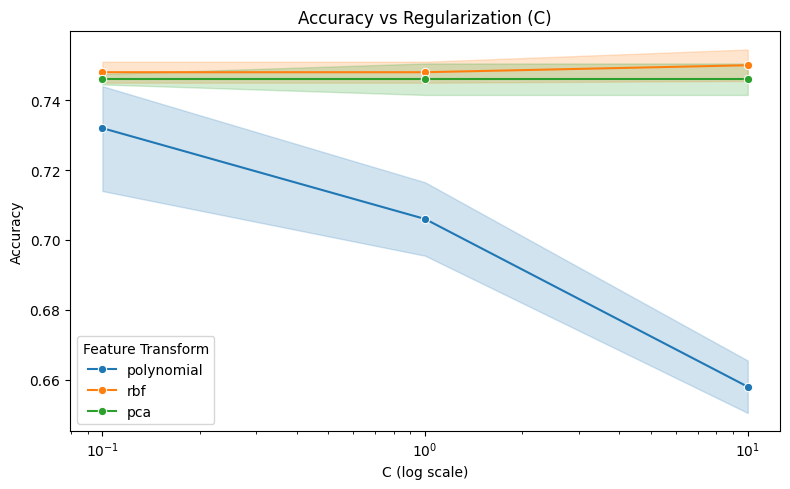

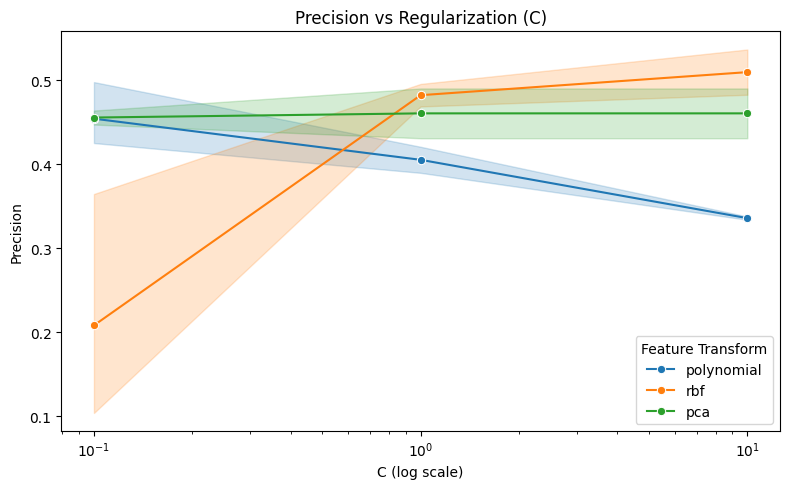

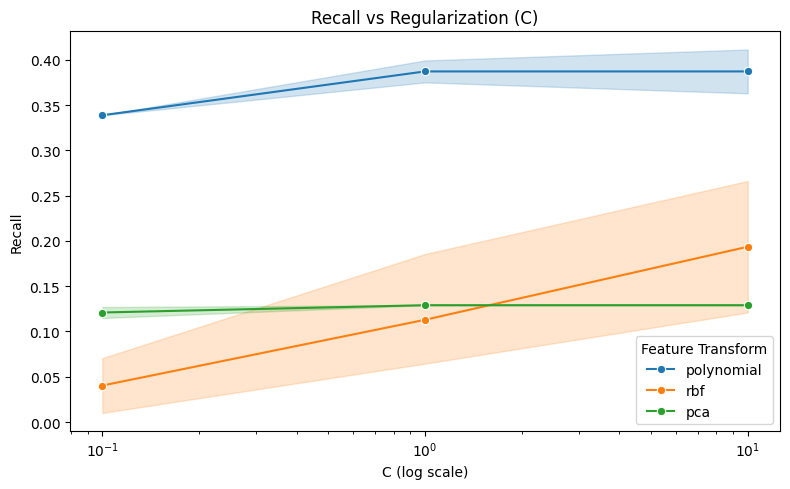

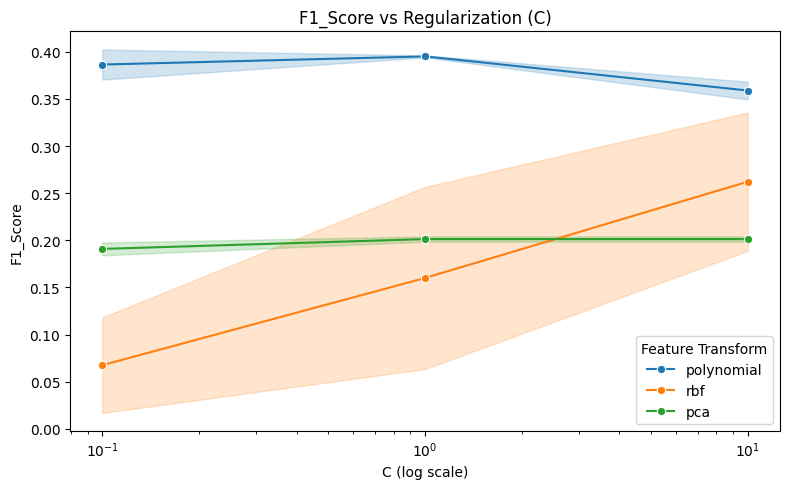

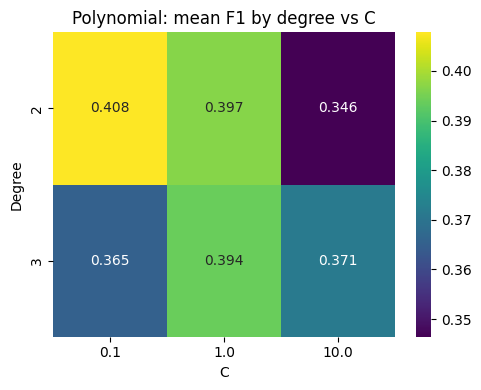

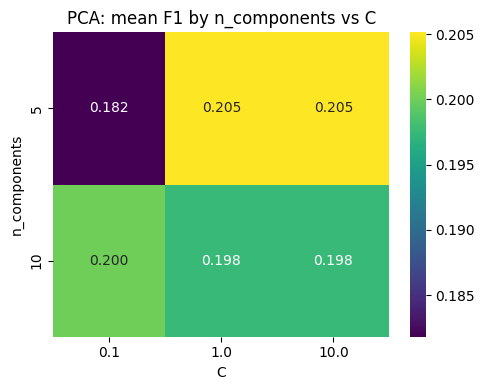

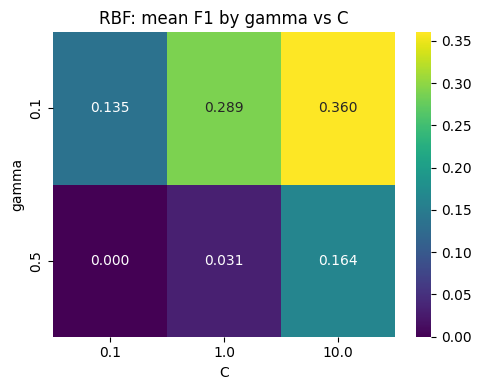

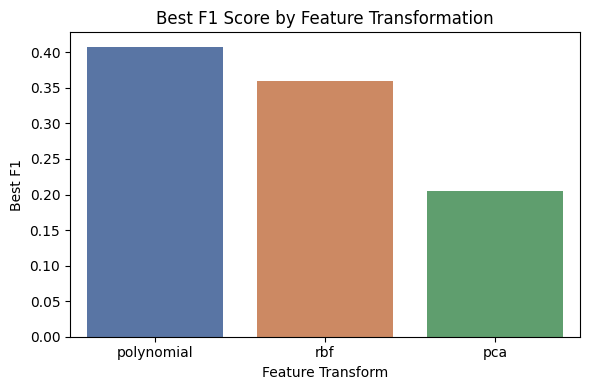

In [ ]:


# … assume you’ve already built `results` … #

# 1) Line‐plots of each metric vs C (unchanged)
metrics = ['accuracy','precision','recall','f1_score']
for metric in metrics:
    plt.figure(figsize=(8,5))
    sns.lineplot(
        data   = results,
        x      = 'C',
        y      = metric,
        hue    = 'feature_method',
        marker = 'o'
    )
    plt.xscale('log')
    plt.title(f'{metric.title()} vs Regularization (C)')
    plt.ylabel(metric.title())
    plt.xlabel('C (log scale)')
    plt.legend(title='Feature Transform')
    plt.tight_layout()
    plt.show()


# 2) Heatmap for Polynomial: mean F1 by degree vs C
poly = results[results['feature_method']=='polynomial']
if not poly.empty:
    pivot_poly = poly.pivot_table(
        index='degree',
        columns='C',
        values='f1_score',
        aggfunc='mean'
    )
    plt.figure(figsize=(5,4))
    sns.heatmap(pivot_poly, annot=True, fmt='.3f', cmap='viridis')
    plt.title('Polynomial: mean F1 by degree vs C')
    plt.ylabel('Degree')
    plt.xlabel('C')
    plt.tight_layout()
    plt.show()


# 3) Heatmap for PCA: mean F1 by n_components vs C
pca = results[results['feature_method']=='pca']
if not pca.empty:
    pivot_pca = pca.pivot_table(
        index='n_components',
        columns='C',
        values='f1_score',
        aggfunc='mean'
    )
    plt.figure(figsize=(5,4))
    sns.heatmap(pivot_pca, annot=True, fmt='.3f', cmap='viridis')
    plt.title('PCA: mean F1 by n_components vs C')
    plt.ylabel('n_components')
    plt.xlabel('C')
    plt.tight_layout()
    plt.show()


# 4) Heatmap for RBF: mean F1 by gamma vs C
rbf = results[results['feature_method']=='rbf']
if not rbf.empty:
    pivot_rbf = rbf.pivot_table(
        index='gamma',
        columns='C',
        values='f1_score',
        aggfunc='mean'
    )
    plt.figure(figsize=(5,4))
    sns.heatmap(pivot_rbf, annot=True, fmt='.3f', cmap='viridis')
    plt.title('RBF: mean F1 by gamma vs C')
    plt.ylabel('gamma')
    plt.xlabel('C')
    plt.tight_layout()
    plt.show()



best_per = (
    results
    .groupby('feature_method', as_index=False)
    ['f1_score']
    .max()
    .sort_values('f1_score', ascending=False)
)

plt.figure(figsize=(6,4))
ax = sns.barplot(
    data    = best_per,
    x       = 'feature_method',
    y       = 'f1_score',
    hue     = 'feature_method',  
    dodge   = False,              
    palette = 'deep'
)
legend = ax.get_legend()
if legend is not None:
    legend.remove()


plt.title('Best F1 Score by Feature Transformation')
plt.ylabel('Best F1')
plt.xlabel('Feature Transform')
plt.tight_layout()
plt.show()
